
# **Candidate Number : 291736**

## 1. Imported Libraries

In [1]:
import os
import glob
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import joblib
import numpy as np

## 2. Load Data

In [2]:
data_dir = 'C:\\Users\\rohan\\OneDrive\\Desktop\\ml project\\Dataset'
df_paths = glob.glob(os.path.join(data_dir, '*.csv'))
datasets = {os.path.splitext(os.path.basename(p))[0]: pd.read_csv(p)
            for p in df_paths}

In [3]:
# Load all CSVs into a dict
df_paths = glob.glob(os.path.join(data_dir, '*.csv'))
datasets = {
    os.path.splitext(os.path.basename(p))[0]: pd.read_csv(p)
    for p in df_paths
}
datasets

{'CanopInt_inst_data':         longitude  latitude  CanopInt_inst_month_1  CanopInt_inst_month_2  \
 0           -71.5     -54.5               0.102090               0.157268   
 1           -70.5     -54.5               0.093179               0.132215   
 2           -69.5     -54.5               0.092867               0.134192   
 3           -68.5     -54.5               0.114641               0.156808   
 4           -67.5     -54.5               0.132172               0.174698   
 ...           ...       ...                    ...                    ...   
 194293       23.5      79.5               0.000052               0.000052   
 194294       24.5      79.5               0.001579               0.001579   
 194295       96.5      79.5               0.001927               0.001927   
 194296       97.5      79.5               0.001987               0.001987   
 194297       98.5      79.5               0.000270               0.000270   
 
         CanopInt_inst_month_3  CanopInt

## 3. Preprocessing Functions

*I m defining a functions to process country-level and spatial (gridded) datasets.*

In [4]:
# Lookup for country centroids
df_lookup = datasets['country_latitude_longitude_area_lookup']
df_lookup = df_lookup.rename(columns={'centroid latitude':'latitude',
                                      'centroid longitude':'longitude',
                                      'country':'Area'})[['Area','latitude','longitude']]
# round for merge
for col in ['latitude','longitude']:
    df_lookup[f'{col}_r'] = df_lookup[col].round(2)

# Process yield DataFrame
def process_yield(df):
    df2 = df[df['Element'].str.contains('Yield', case=False, na=False)].copy()
    df2 = df2.rename(columns={'Country':'Area','Year':'Year','Value':'Yield'})
    return df2[['Area','Year','Yield']]

# Process spatial (gridded) DataFrame
def process_spatial(df, name):
    df2 = df.copy()
    month_cols = [c for c in df2.columns if 'month_' in c.lower()]
    df2[name] = df2[month_cols].mean(axis=1)
    df2['latitude_r'] = df2['latitude'].round(2)
    df2['longitude_r'] = df2['longitude'].round(2)
    df2 = df2.rename(columns={'year':'Year'})
    df2 = df2.merge(df_lookup[['Area','latitude_r','longitude_r']],
                   on=['latitude_r','longitude_r'], how='inner')
    return df2[['Area','Year',name]]

# Process country-level DataFrame
def process_generic(df, name):
    df2 = df.copy()
    val = 'Value' if 'Value' in df2.columns else [c for c in df2.columns
                                                 if c.lower() not in ['country','area','year']][-1]
    rename_map = {'Country':'Area','Year':'Year', val:name}
    df2 = df2.rename(columns={k:v for k,v in rename_map.items() if k in df2.columns})
    return df2[['Area','Year',name]]

## 4. Build Feature DataFrames & Merge

In [5]:
# Identify yield dataset
yield_key = [k for k in datasets if 'Yield_and_Production_data'.lower() in k.lower()][0]
yield_df = process_yield(datasets[yield_key])

# Initialize feature list with current-year yield as a predictor
feature_dfs = [yield_df]
feature_names = ['Yield']  # include current-year yield

# Process remaining datasets
temp_keys = []
for key, df in datasets.items():
    if key in [yield_key, 'country_latitude_longitude_area_lookup']:
        continue
    if {'latitude','longitude','year'}.issubset(df.columns) and any('month_' in c for c in df.columns):
        feat = process_spatial(df, key)
    elif 'Country' in df.columns and 'Value' in df.columns:
        feat = process_generic(df, key)
    else:
        continue
    feature_dfs.append(feat)
    feature_names.append(key)
    temp_keys.append(key)

# Outer merge all
df_list = feature_dfs.copy()
full_df = reduce(lambda a,b: pd.merge(a,b,on=['Area','Year'], how='outer'), df_list)
print(f"Merged full_df shape: {full_df.shape}")

# Keep only known yields
df_yield = full_df[full_df['Yield'].notna()].copy()
# Ensure Yield is present in feature_names
if 'Yield' not in feature_names:
    feature_names.insert(0, 'Yield')

# Identify and drop feature columns that are all NaN
all_nan = [col for col in feature_names if df_yield[col].isna().all()]
if all_nan:
    df_yield.drop(columns=all_nan, inplace=True)
    feature_names = [col for col in feature_names if col not in all_nan]
    print(f"Dropped all-NaN feature columns: {all_nan}")

# Replace infinite values then impute remaining NaNs by mean
df_yield.replace([np.inf, -np.inf], np.nan, inplace=True)
df_yield[feature_names] = df_yield[feature_names].apply(lambda c: c.fillna(c.mean()))

# Verify
if df_yield[feature_names].isna().any().any():
    raise ValueError("NaNs remain after imputation. Please check data.")
print(f"After filter/impute: {df_yield.shape}")

Merged full_df shape: (75473, 17)
Dropped all-NaN feature columns: ['CanopInt_inst_data', 'ESoil_tavg_data', 'Rainf_tavg_data', 'Snowf_tavg_data', 'SoilMoi0_10cm_inst_data', 'SoilMoi100_200cm_inst_data', 'SoilMoi10_40cm_inst_data', 'SoilMoi40_100cm_inst_data', 'SoilTMP0_10cm_inst_data', 'SoilTMP100_200cm_inst_data', 'SoilTMP10_40cm_inst_data', 'SoilTMP40_100cm_inst_data', 'TVeg_tavg_data', 'TWS_inst_data']
After filter/impute: (75473, 3)


## 5. Create Targets & Split Data

In [6]:
# Shift Yield to get next-year target
df_yield = df_yield.sort_values(['Area','Year'])
df_yield['Yield_next'] = df_yield.groupby('Area')['Yield'].shift(-1)
df_yield = df_yield.dropna(subset=['Yield_next'])

X = df_yield[feature_names]
y = df_yield['Yield_next']
# Random train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
# Drop any rows with NaN or infinite feature values before scaling
mask_train = np.isfinite(X_train).all(axis=1)
mask_test = np.isfinite(X_test).all(axis=1)
X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_test = X_test[mask_test]
y_test = y_test[mask_test]
print(f"After cleaning: Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 60218, Test samples: 15055
After cleaning: Train samples: 60218, Test samples: 15055


## 6. Scale & Train MLP

In [7]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
mlp = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                   learning_rate_init=1e-3, max_iter=200, random_state=42)
mlp.fit(X_train_scaled, y_train)


MLPRegressor(hidden_layer_sizes=(64, 32), random_state=42)

## 7. Evaluate & Save Outputs

MAE: 8787.5027
RMSE: 14259.6783
R2: 0.0098
→ Saved predictions.csv
→ Saved predicted_vs_actual.png


['scaler.save']

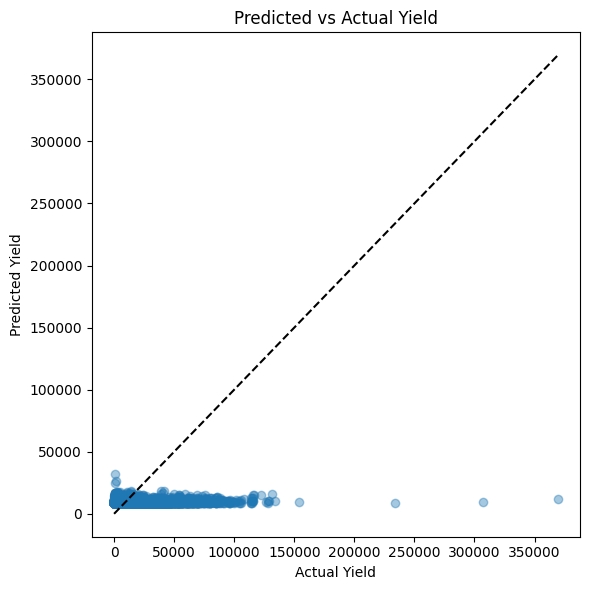

In [8]:
## 7. Evaluate & Save Outputs

# Predict & metrics
preds = mlp.predict(X_test_scaled)
mae  = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2   = r2_score(y_test, preds)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Save predictions
results = df_yield.loc[y_test.index, ['Area','Year']].copy()
results['ActualYield']    = y_test.values
results['PredictedYield'] = preds
results.to_csv('predictions.csv', index=False)
print("→ Saved predictions.csv")

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs Actual Yield')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=300)
print("→ Saved predicted_vs_actual.png")

# Save model & scaler
joblib.dump(mlp, 'mlp_model.joblib')
joblib.dump(scaler, 'scaler.save')
